# Importamos las librerias

In [16]:
#!pip install pmdarima
#conda install -c conda-forge fbprophet
#!pip install plotly

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Running setup.py clean for fbprophet
Failed to build fbprophet
    Running setup.py install for fbprophet: started
    Running setup.py install for fbprophet: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\fleguiza\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\fleguiza\\AppData\\Local\\Temp\\pip-install-m1oj_twy\\fbprophet\\setup.py'"'"'; __file__='"'"'C:\\Users\\fleguiza\\AppData\\Local\\Temp\\pip-install-m1oj_twy\\fbprophet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\fleguiza\AppData\Local\Temp\pip-wheel-wr9l9x1a'
       cwd: C:\Users\fleguiza\AppData\Local\Temp\pip-install-m1oj_twy\fbprophet\
  Complete output (10 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5236004a3fd5b8429270d00efcc0cf9 NOW.
  error: Microsoft Visual C++ 14.0

In [1]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from pylab import rcParams
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import iplot
import random
#import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 11})
#from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
#init_notebook_mode(connected=False)
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import ParameterGrid
from fbprophet import Prophet

# Funciones

## Funciones Descriptivos

In [2]:
def ploteo_serie_sns(df,x,y):
  fig = px.line(df, x=x, y=y)
  fig.show()


def date_features(df,x,y):
    df = df.copy()

    df['date'] = df[x]
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    x1 = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y1 = df[y]
    df_new = pd.concat([x1, y1], axis=1)
    return df_new


def ploteo_seasonal (df_new):
  fig = px.bar(df_new, x="month", color="year",
              y='y',
              title="Data by month",
              barmode='group',
              height=600
              )

  fig.show()

"""
  fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
  fig.set_size_inches(20,30)

  monthAggregated = pd.DataFrame(df_new.groupby("month")["y"].sum()).reset_index().sort_values('y')
  sns.barplot(data=monthAggregated,x="month",y="y",ax=ax1)
  ax1.set(xlabel='Month', ylabel='y')
  ax1.set_title("Sum data By Month",fontsize=15)

  monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["y"].sum()).reset_index().sort_values('y')
  sns.barplot(data=monthAggregated,x="dayofweek",y="y",ax=ax2)
  ax2.set(xlabel='dayofweek', ylabel='y')
  ax2.set_title("Sum data By Weekday",fontsize=15)

  monthAggregated = pd.DataFrame(df_new.groupby("quarter")["y"].sum()).reset_index().sort_values('y')
  sns.barplot(data=monthAggregated,x="quarter",y="y",ax=ax3)
  ax3.set(xlabel='Quarter', ylabel='y')
  ax3.set_title("Sum data By Quarter",fontsize=15)

  monthAggregated = pd.DataFrame(df_new.groupby("year")["y"].sum()).reset_index().sort_values('y')
  sns.barplot(data=monthAggregated,x="year",y="y",ax=ax4)
  ax4.set(xlabel='year', ylabel='y')
  ax4.set_title("Sum data By year",fontsize=15)

"""

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualizar predicción con plotly."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='rgb(255,0,0)'))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='rgb(255,0,0)'),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # Notar que el orden es importante
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='TGMV'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

## Funciones Predictivas

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def forecast_prophet (country_name,prediction_size,df,mult = 1):

    train_df = df.copy()
    train_df = train_df[:-prediction_size]

    #Definimos la grilla de hiperparámetros para tunear prophet

    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    change = list (np.linspace ( start = 0.001, stop = 0.5, num = 11, endpoint = True))
    seasonality = list (np.linspace ( start = 0.01, stop = 10, num = 10, endpoint = True))
    holidayss = list (np.linspace ( start = 0.01, stop = 10, num = 1, endpoint = True))

    
    params_grid = {'seasonality_mode':['additive','multiplicative'],
                  'changepoint_prior_scale': change,
                  'seasonality_prior_scale': seasonality,
                  #'holidays_prior_scale': holidayss
                  }
    grid = ParameterGrid(params_grid)
    cnt = 0
    for p in grid:
        cnt = cnt+1
        
    print('Total Possible Models',cnt)

    #Elige el mejor modelo en base a test

    i = 0
    for p in grid:
        test = pd.DataFrame()
        print(p)
        random.seed(0)
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                            #holidays_prior_scale = p['holidays_prior_scale'],
                            #n_changepoints = p['n_changepoints'],
                            seasonality_mode = p['seasonality_mode'],
                            seasonality_prior_scale = p['seasonality_prior_scale'],
                            weekly_seasonality=True,
                            daily_seasonality = True,
                            yearly_seasonality = True,
                            holidays=holiday, 
                            interval_width=0.95
                            )
        if country_name == "URU":
          z = 1
        else:
          train_model.add_country_holidays(country_name=country_name)
        train_model.fit(train_df)

        
        future = train_model.make_future_dataframe(periods=prediction_size)
        forecast = train_model.predict(future)
        cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
        cmp_df = cmp_df[-prediction_size:]
        MAPE = mean_absolute_percentage_error(cmp_df['y'],cmp_df['yhat'])
        print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
        model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
        i = i +1
        print("Falta ",cnt-i)

    #Guarda todas las configuraciones de modelos que consiguió

    parameters = model_parameters.sort_values(by=['MAPE'])
    parameters = parameters.reset_index(drop=True)
    display (parameters.head())

    # Se queda con la que mejor MAPE tuvo

    winner  = parameters['Parameters'][0]
    print(winner)
    df

    #Vuelve a entrenar con la configuración ganadora y predice


    #Entrenamos con train+test
    train_df = df.copy()

    train_model =Prophet(changepoint_prior_scale = winner['changepoint_prior_scale'],
                            #holidays_prior_scale = p['holidays_prior_scale'],
                            #n_changepoints = p['n_changepoints'],
                            seasonality_mode = winner['seasonality_mode'],
                            seasonality_prior_scale = winner['seasonality_prior_scale'],
                            weekly_seasonality=True,
                            daily_seasonality = True,
                            yearly_seasonality = True,
                            holidays=holiday, 
                            interval_width=0.95
                            )
    if country_name == "URU":
      z = 1
    else:
      train_model.add_country_holidays(country_name=country_name)
    train_model.fit(train_df)
    future = train_model.make_future_dataframe(periods=prediction_size*mult)
    forecast = train_model.predict(future)
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]



#     Entrenamos modelo

## Levantamos las bases

In [4]:
#Levantamos el CSV
df = pd.read_csv('Series_paises_v4.csv',sep =";",decimal = ',')
#df['TIM_DAY_WINNING_DATE']= pd.DatetimeIndex(df['MES'],dayfirst =True)
#df.set_index('TIM_DAY_WINNING_DATE',inplace =True)
display(df)
#df = df[["TIM_DAY_WINNING_DATE",'TGMV_LC','TSI']]
#df.columns = ["ds","TGMV_LC",'TSI']
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

holiday_c = pd.read_csv('Holidays_ALL_v3.csv',sep =";")
holiday_c['ds'] = pd.to_datetime(holiday_c['ds'], format='%d/%m/%Y')

display(df,holiday_c)


"""
#Cargamos los aumentos
#serie_aumento =pd.read_csv("Serie_Aumento.csv",sep=";")
#Damos formato de fecha a la variable mes

df.set_index('MES',inplace =True)
#serie_aumento['MES'] = pd.DatetimeIndex(serie_aumento['MES'],dayfirst =True)
#display(df,serie_aumento)
display(df)"""

ds    COL_TGMV    ARG_TGMV   BRA_TGMV    CHL_TGMV   MEX_TGMV  \
0      1/1/2018   267031199    34344046   16360748   113664462   18400505   
1      2/1/2018  1423404157   153327266   41649619   354272865   58567083   
2      3/1/2018  1490670950   147515823   69983403   330863085   59139183   
3      4/1/2018  1312948706   137908215   58956409   293936143   54811855   
4      5/1/2018  1255181497   125831966   54499191   240634694   49057554   
...         ...         ...         ...        ...         ...        ...   
1134   8/2/2021  6440971786  1482187640  142589705  2884725205  296460694   
1135   9/2/2021  6021689922  1423259229  192546048  2661895679  299984270   
1136  10/2/2021  5626828041  1368494794  168360391  2570554748  286131967   
1137  11/2/2021  5345949701  1283133573  160518059  2339865331  270940712   
1138  12/2/2021  4725522778  1131077660  142140548  1975140787  257145196   

      URU_TGMV  PER_TGMV  COL_TSI  ARG_TSI  BRA_TSI  CHL_TSI  MEX_TSI  \
0      5265089     95763     3072    34498   159403     8514    34305   
1     25240809    262526    14998   157811   392569    13780   105152   
2     23710287    273606    15720   156348   716468    13378   113102   
3     24819211    332428    14448   148125   590838    11703   105541   
4     20002984    258067    13047   137993   542922     9576    90863   
...        ...       ...      ...      ...      ...      ...      ...   
1134  44273189    862495    73844   493519  1102662   151668   634018   
1135  40530753    836748    67818   483570  1509403   139595   639229   
1136  38121887    827942    64197   477584  1325052   134000   624066   
1137  37550768    862789    60838   440899  1251461   120017   580784   
1138  30804470    780382    52734   362634  1090876   100185   546473   

      URU_TSI  PER_TSI  
0        3254      815  
1       16912     2068  
2       17443     2338  
3       16189     2246  
4       13108     2191  
...       ...      ...  
1134    28720     6936  
1135    26308     6453  
1136    25306     5901  
1137    23477     6139  
1138    20023     5530  

[1139 rows x 15 columns]

ds    COL_TGMV    ARG_TGMV   BRA_TGMV    CHL_TGMV   MEX_TGMV  \
0    2018-01-01   267031199    34344046   16360748   113664462   18400505   
1    2018-01-02  1423404157   153327266   41649619   354272865   58567083   
2    2018-01-03  1490670950   147515823   69983403   330863085   59139183   
3    2018-01-04  1312948706   137908215   58956409   293936143   54811855   
4    2018-01-05  1255181497   125831966   54499191   240634694   49057554   
...         ...         ...         ...        ...         ...        ...   
1134 2021-02-08  6440971786  1482187640  142589705  2884725205  296460694   
1135 2021-02-09  6021689922  1423259229  192546048  2661895679  299984270   
1136 2021-02-10  5626828041  1368494794  168360391  2570554748  286131967   
1137 2021-02-11  5345949701  1283133573  160518059  2339865331  270940712   
1138 2021-02-12  4725522778  1131077660  142140548  1975140787  257145196   

      URU_TGMV  PER_TGMV  COL_TSI  ARG_TSI  BRA_TSI  CHL_TSI  MEX_TSI  \
0      5265089     95763     3072    34498   159403     8514    34305   
1     25240809    262526    14998   157811   392569    13780   105152   
2     23710287    273606    15720   156348   716468    13378   113102   
3     24819211    332428    14448   148125   590838    11703   105541   
4     20002984    258067    13047   137993   542922     9576    90863   
...        ...       ...      ...      ...      ...      ...      ...   
1134  44273189    862495    73844   493519  1102662   151668   634018   
1135  40530753    836748    67818   483570  1509403   139595   639229   
1136  38121887    827942    64197   477584  1325052   134000   624066   
1137  37550768    862789    60838   440899  1251461   120017   580784   
1138  30804470    780382    52734   362634  1090876   100185   546473   

      URU_TSI  PER_TSI  
0        3254      815  
1       16912     2068  
2       17443     2338  
3       16189     2246  
4       13108     2191  
...       ...      ...  
1134    28720     6936  
1135    26308     6453  
1136    25306     5901  
1137    23477     6139  
1138    20023     5530  

[1139 rows x 15 columns]

ds            holiday pais
0   2018-01-01           Ano novo  BRA
1   2018-01-08  Saldao de Janeiro  BRA
2   2018-01-09  Saldao de Janeiro  BRA
3   2018-01-10  Saldao de Janeiro  BRA
4   2018-01-11  Saldao de Janeiro  BRA
..         ...                ...  ...
935 2021-11-22        preybuenfin  MEX
936 2021-12-24            navidad  MEX
937 2021-12-25            navidad  MEX
938 2021-12-31          ano nuevo  MEX
939 2022-01-01          ano nuevo  MEX

[940 rows x 3 columns]

'\n#Cargamos los aumentos\n#serie_aumento =pd.read_csv("Serie_Aumento.csv",sep=";")\n#Damos formato de fecha a la variable mes\n\ndf.set_index(\'MES\',inplace =True)\n#serie_aumento[\'MES\'] = pd.DatetimeIndex(serie_aumento[\'MES\'],dayfirst =True)\n#display(df,serie_aumento)\ndisplay(df)'

In [15]:
#df = df[['ds','COL_TGMV','ARG_TGMV','BRA_TGMV','CHL_TGMV','MEX_TGMV','URU_TGMV','PER_TGMV']]
#lala.columns=['ds','y']
#ploteo_serie_sns (lala,"ds","y")

In [ ]:
#Hiperparámetros de la función


#country_name = "BRA"
prediction_size = 90
fecha_corte_ous = '2020-11-14'


df.set_index('ds',inplace =True)


vars = list(df.columns)
df2 = df.copy()



for var in vars:
  df = df2.copy()
  df = df2[[var]]

  country_name = var[:3]

  holiday = holiday_c.copy()
  holiday = holiday.loc[holiday.pais == country_name,:]
  holiday.drop(columns='pais',inplace=True)
  holiday
  
  df["ds"] = df.index
  display(df)
  df.rename(columns = {var:'y'},inplace =True)


  # Armamos la muestra out of sample para comparar
  test_ous = df.copy()
  test_ous = df.loc[df.ds >= fecha_corte_ous,:]
  df = df.loc[df.ds < fecha_corte_ous,:] 

  test_ous.set_index('ds',inplace =True)


  display (df,test_ous)





#Ploteamos

  #ploteo_serie_sns (df,"ds","y")
  #df_new = date_features(df.loc[df.ds < '2021-01-01',:], x = 'ds',y='y')
  #ploteo_seasonal (df_new)


  forecast = forecast_prophet (country_name,prediction_size,df)


  df = pd.concat([df[['y']],test_ous],axis =0) 
  union = pd.concat ([forecast[['yhat', 'yhat_lower', 'yhat_upper']],df],axis = 1, join = 'outer')
  #df.rename(columns = {'y':var},inplace =True)

  show_forecast(union, prediction_size, 500, 'Forecast '+var)
  forecast.rename(columns = {'yhat':var+'_yhat','yhat_lower':var+'_yhat_lower','yhat_upper':var+'_yhat_upper'},inplace =True)

  # Nos quedamos con el forecast

  if vars.index(var) == 0:
    salida = forecast.copy()
  else:
    salida = pd.concat ([salida,forecast],axis = 1, join = 'outer')


display(forecast)

<ipython-input-5-a0458e2352a3>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



COL_TGMV         ds
ds                               
2018-01-01   267031199 2018-01-01
2018-01-02  1423404157 2018-01-02
2018-01-03  1490670950 2018-01-03
2018-01-04  1312948706 2018-01-04
2018-01-05  1255181497 2018-01-05
...                ...        ...
2021-02-08  6440971786 2021-02-08
2021-02-09  6021689922 2021-02-09
2021-02-10  5626828041 2021-02-10
2021-02-11  5345949701 2021-02-11
2021-02-12  4725522778 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                               
2018-01-01   267031199 2018-01-01
2018-01-02  1423404157 2018-01-02
2018-01-03  1490670950 2018-01-03
2018-01-04  1312948706 2018-01-04
2018-01-05  1255181497 2018-01-05
...                ...        ...
2020-11-09  5510868538 2020-11-09
2020-11-10  5019134225 2020-11-10
2020-11-11  4921345247 2020-11-11
2020-11-12  4522067974 2020-11-12
2020-11-13  4039433337 2020-11-13

[1048 rows x 2 columns]

y
ds                    
2020-11-14  3335598197
2020-11-15  2409188822
2020-11-16  3177146527
2020-11-17  5598920140
2020-11-18  5065079759
...                ...
2021-02-08  6440971786
2021-02-09  6021689922
2021-02-10  5626828041
2021-02-11  5345949701
2021-02-12  4725522778

[91 rows x 1 columns]

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.125698198893367
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.55565617344312
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.650832438077746
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.880856486190833
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.178325217883405
Falta  215
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 38.87088324186175
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.83178970626745
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.14016034688641
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 36.831419019396314
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.266927989013084
Falta  175
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 41.34834396220321
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.71037130609907
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.48273341686464
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.95746930521229
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 36.16236259488489
Falta  135
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior

Mean Absolute Percentage Error(MAPE)------------------------------------ 44.2236254265275
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.904406620094925
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.73051291877039
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 38.38421640051688
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.94581333292798
Falta  95
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scal

Mean Absolute Percentage Error(MAPE)------------------------------------ 47.606686879194214
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.81847142645268
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.04849134451672
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.76896440312446
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.25890418661298
Falta  55
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_sca

Mean Absolute Percentage Error(MAPE)------------------------------------ 49.09501383244097
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 43.75060721495307
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 41.78084128859417
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 41.25459363352636
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 41.35966408476677
Falta  15
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.560000000

MAPE                                         Parameters
0  14.366228  {'changepoint_prior_scale': 0.001, 'seasonalit...
1  14.650832  {'changepoint_prior_scale': 0.001, 'seasonalit...
2  14.957351  {'changepoint_prior_scale': 0.001, 'seasonalit...
3  15.761201  {'changepoint_prior_scale': 0.001, 'seasonalit...
4  16.125698  {'changepoint_prior_scale': 0.001, 'seasonalit...

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.5600000000000005}


<ipython-input-5-a0458e2352a3>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ARG_TGMV         ds
ds                               
2018-01-01    34344046 2018-01-01
2018-01-02   153327266 2018-01-02
2018-01-03   147515823 2018-01-03
2018-01-04   137908215 2018-01-04
2018-01-05   125831966 2018-01-05
...                ...        ...
2021-02-08  1482187640 2021-02-08
2021-02-09  1423259229 2021-02-09
2021-02-10  1368494794 2021-02-10
2021-02-11  1283133573 2021-02-11
2021-02-12  1131077660 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                               
2018-01-01    34344046 2018-01-01
2018-01-02   153327266 2018-01-02
2018-01-03   147515823 2018-01-03
2018-01-04   137908215 2018-01-04
2018-01-05   125831966 2018-01-05
...                ...        ...
2020-11-09  1553543593 2020-11-09
2020-11-10  1361817948 2020-11-10
2020-11-11  1310690459 2020-11-11
2020-11-12  1252214090 2020-11-12
2020-11-13  1119466280 2020-11-13

[1048 rows x 2 columns]

y
ds                    
2020-11-14   806754892
2020-11-15   734169653
2020-11-16  1263967781
2020-11-17  1295059794
2020-11-18  1214539458
...                ...
2021-02-08  1482187640
2021-02-09  1423259229
2021-02-10  1368494794
2021-02-11  1283133573
2021-02-12  1131077660

[91 rows x 1 columns]

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 36.06472374076366
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.718562240219136
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.62179493253017
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.6341330922801
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 12.186414929986764
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.592253788556896
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.2342254256523
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.05974051904591
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.96231733831938
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.82053618432595
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.530813083750974
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.99664200443257
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.20175951471217
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.735635714660084
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 18.098300705442753
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.64183974458798
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.075035758871365
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.628391217610325
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.83689635370666
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 19.09199426546349
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.268810956138886
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.44943949314261
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.403367804991365
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.878474441321536
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_s

Mean Absolute Percentage Error(MAPE)------------------------------------ 18.92414987314285
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.81568363985405
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.454410822713434
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.08298880023229
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.316309485858643
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mea

MAPE                                         Parameters
0  10.877529  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  10.967124  {'changepoint_prior_scale': 0.0509, 'seasonali...
2  11.173504  {'changepoint_prior_scale': 0.0509, 'seasonali...
3  11.243181  {'changepoint_prior_scale': 0.0509, 'seasonali...
4  11.251550  {'changepoint_prior_scale': 0.0509, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.34}


<ipython-input-5-a0458e2352a3>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



BRA_TGMV         ds
ds                              
2018-01-01   16360748 2018-01-01
2018-01-02   41649619 2018-01-02
2018-01-03   69983403 2018-01-03
2018-01-04   58956409 2018-01-04
2018-01-05   54499191 2018-01-05
...               ...        ...
2021-02-08  142589705 2021-02-08
2021-02-09  192546048 2021-02-09
2021-02-10  168360391 2021-02-10
2021-02-11  160518059 2021-02-11
2021-02-12  142140548 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                              
2018-01-01   16360748 2018-01-01
2018-01-02   41649619 2018-01-02
2018-01-03   69983403 2018-01-03
2018-01-04   58956409 2018-01-04
2018-01-05   54499191 2018-01-05
...               ...        ...
2020-11-09  150014142 2020-11-09
2020-11-10  203453356 2020-11-10
2020-11-11  186460224 2020-11-11
2020-11-12  177432813 2020-11-12
2020-11-13  151681283 2020-11-13

[1048 rows x 2 columns]

y
ds                   
2020-11-14  116993048
2020-11-15   85875881
2020-11-16  146300843
2020-11-17  203702442
2020-11-18  179501499
...               ...
2021-02-08  142589705
2021-02-09  192546048
2021-02-10  168360391
2021-02-11  160518059
2021-02-12  142140548

[91 rows x 1 columns]

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.24644582679906
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.467679527362982
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}


In [ ]:
salida_def = salida.copy()
#salida_def = salida_def.loc[salida_def.index >= fecha_corte_ous,:]
salida_def.to_csv('salida_def_final_nov_ssj_90.csv',sep=';',decimal =',')

### Graficos

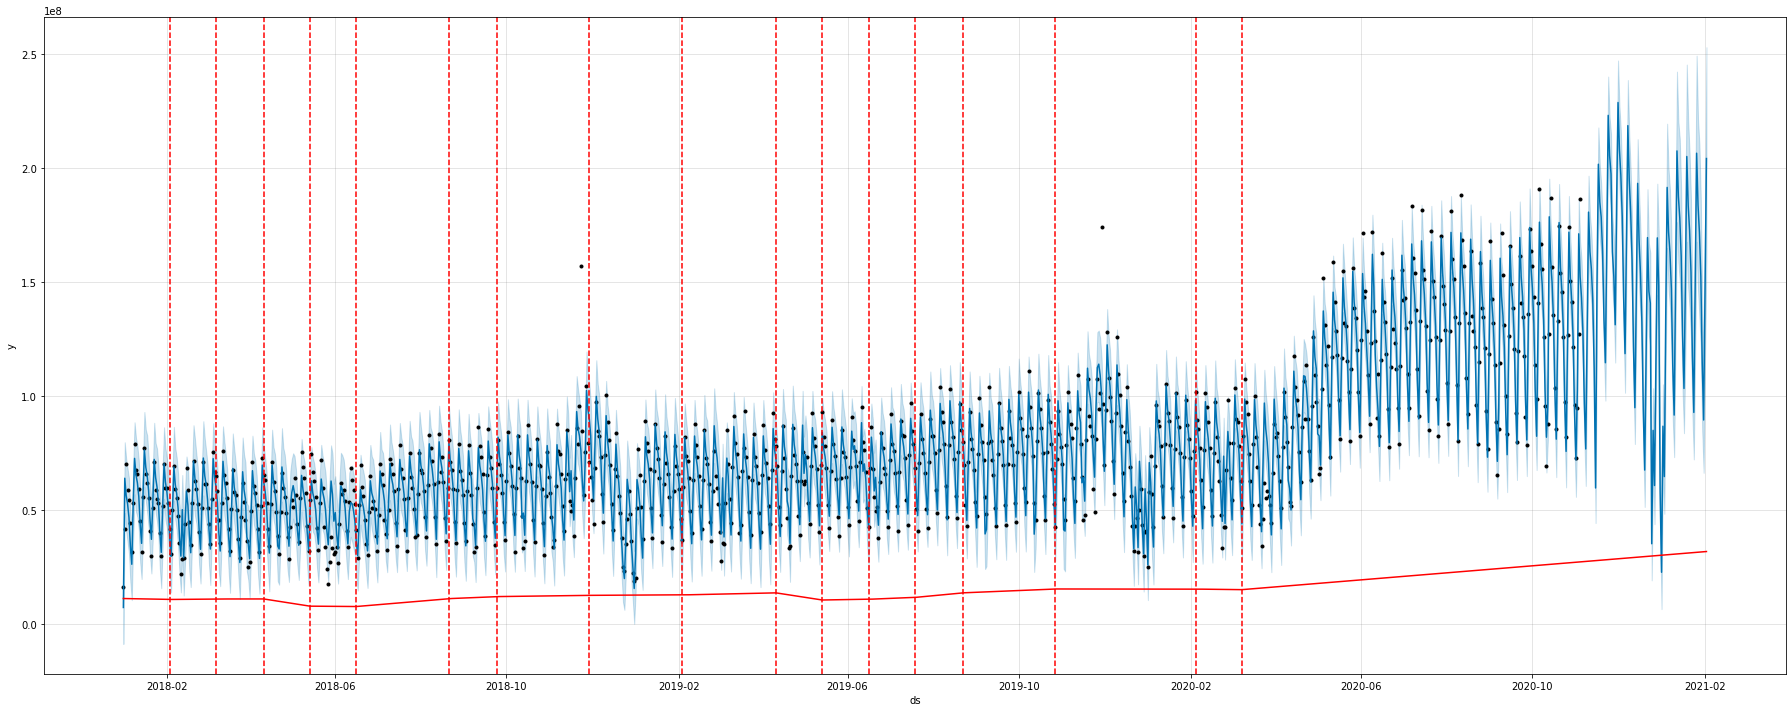

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig1 = train_model.plot(forecast,figsize=(25,10))
b = add_changepoints_to_plot(fig1.gca(), train_model, forecast)
# Los changepoints marcados en rojo son puntos donde cambia la tendencia de la serie. Prophet los detecta automaticamente pero se pueden meter a mano.

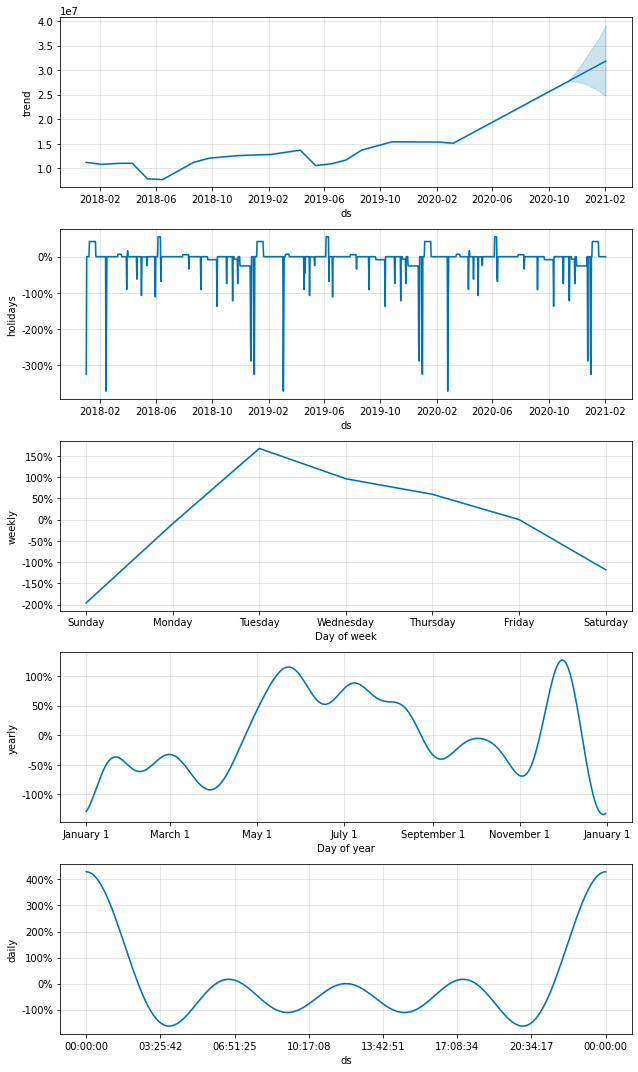

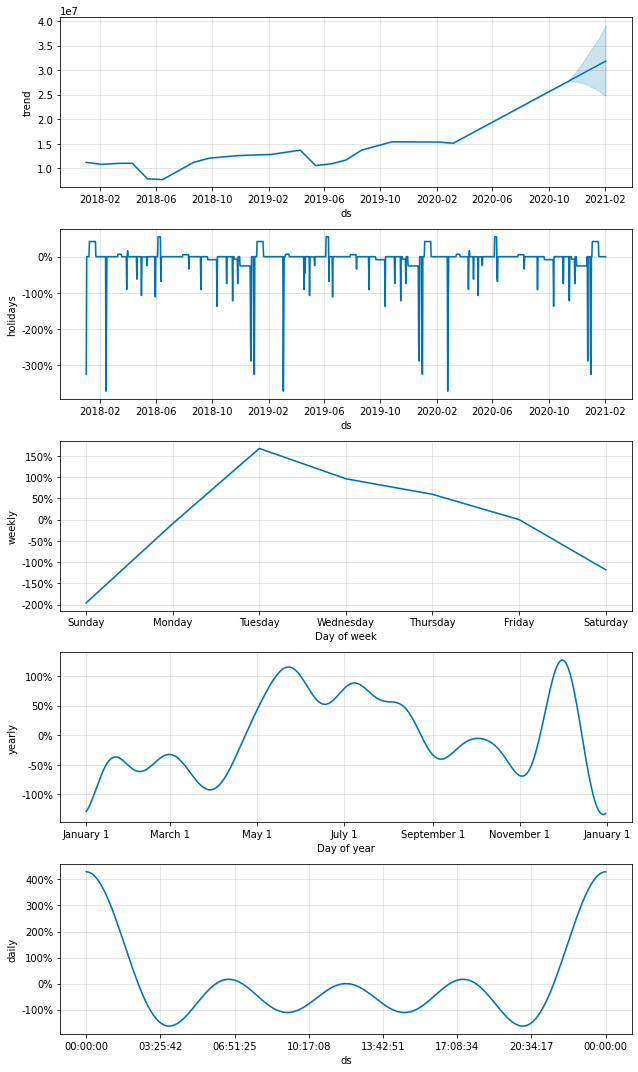

In [ ]:
train_model.plot_components(forecast,(25,10))

In [43]:
print(train_model.train_holiday_names)

NameError: name 'train_model' is not defined

# Modelo 360

In [39]:
#Levantamos el CSV
df = pd.read_csv('Series_paises_v4.csv',sep =";",decimal = ',')
#df['TIM_DAY_WINNING_DATE']= pd.DatetimeIndex(df['MES'],dayfirst =True)
#df.set_index('TIM_DAY_WINNING_DATE',inplace =True)
#display(df)
#df = df[["TIM_DAY_WINNING_DATE",'TGMV_LC','TSI']]
#df.columns = ["ds","TGMV_LC",'TSI']
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

holiday_c = pd.read_csv('Holidays_ALL_v3.csv',sep =";")
holiday_c['ds'] = pd.to_datetime(holiday_c['ds'], format='%d/%m/%Y')

#display(df,holiday_c)


"""
#Cargamos los aumentos
#serie_aumento =pd.read_csv("Serie_Aumento.csv",sep=";")
#Damos formato de fecha a la variable mes

df.set_index('MES',inplace =True)
#serie_aumento['MES'] = pd.DatetimeIndex(serie_aumento['MES'],dayfirst =True)
#display(df,serie_aumento)
display(df)"""

'\n#Cargamos los aumentos\n#serie_aumento =pd.read_csv("Serie_Aumento.csv",sep=";")\n#Damos formato de fecha a la variable mes\n\ndf.set_index(\'MES\',inplace =True)\n#serie_aumento[\'MES\'] = pd.DatetimeIndex(serie_aumento[\'MES\'],dayfirst =True)\n#display(df,serie_aumento)\ndisplay(df)'

In [40]:
#Hiperparámetros de la función


#country_name = "BRA"
prediction_size = 180
fecha_corte_ous = '2022-11-05'


df.set_index('ds',inplace =True)


vars = list(df.columns)
df2 = df.copy()



for var in vars:
  df = df2.copy()
  df = df2[[var]]

  country_name = var[:3]

  holiday = holiday_c.copy()
  holiday = holiday.loc[holiday.pais == country_name,:]
  holiday.drop(columns='pais',inplace=True)
  holiday
  
  df["ds"] = df.index
  display(df)
  df.rename(columns = {var:'y'},inplace =True)


  # Armamos la muestra out of sample para comparar
  test_ous = df.copy()
  test_ous = df.loc[df.ds >= fecha_corte_ous,:]
  df = df.loc[df.ds < fecha_corte_ous,:] 

  test_ous.set_index('ds',inplace =True)


  display (df,test_ous)





#Ploteamos

  #ploteo_serie_sns (df,"ds","y")
  #df_new = date_features(df.loc[df.ds < '2021-01-01',:], x = 'ds',y='y')
  #ploteo_seasonal (df_new)


  forecast = forecast_prophet (country_name,prediction_size,df,2)


  df = pd.concat([df[['y']],test_ous],axis =0) 
  union = pd.concat ([forecast[['yhat', 'yhat_lower', 'yhat_upper']],df],axis = 1, join = 'outer')
  #df.rename(columns = {'y':var},inplace =True)

  show_forecast(union, prediction_size*2, 500, 'Forecast '+var)
  forecast.rename(columns = {'yhat':var+'_yhat','yhat_lower':var+'_yhat_lower','yhat_upper':var+'_yhat_upper'},inplace =True)

  # Nos quedamos con el forecast

  if vars.index(var) == 0:
    salida2 = forecast.copy()
  else:
    salida2 = pd.concat ([salida2,forecast],axis = 1, join = 'outer')


display(forecast)

<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



COL_TGMV         ds
ds                               
2018-01-01   267031199 2018-01-01
2018-01-02  1423404157 2018-01-02
2018-01-03  1490670950 2018-01-03
2018-01-04  1312948706 2018-01-04
2018-01-05  1255181497 2018-01-05
...                ...        ...
2021-02-08  6440971786 2021-02-08
2021-02-09  6021689922 2021-02-09
2021-02-10  5626828041 2021-02-10
2021-02-11  5345949701 2021-02-11
2021-02-12  4725522778 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                               
2018-01-01   267031199 2018-01-01
2018-01-02  1423404157 2018-01-02
2018-01-03  1490670950 2018-01-03
2018-01-04  1312948706 2018-01-04
2018-01-05  1255181497 2018-01-05
...                ...        ...
2021-02-08  6440971786 2021-02-08
2021-02-09  6021689922 2021-02-09
2021-02-10  5626828041 2021-02-10
2021-02-11  5345949701 2021-02-11
2021-02-12  4725522778 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.90563521171034
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.896978177161024
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.792771974681493
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.33975456072248
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)----------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 35.42340633591709
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.05478299420192
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.903583570292824
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.44232637080509
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.992504013434996
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 35.87899207326506
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 38.84757625873591
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.9919666192699
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.902557351243928
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.269068606740476
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 36.356460051418274
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 45.94066354992747
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.728998230811804
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.85292522899144
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.287995075343446
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 36.05538135544427
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 50.661727124652586
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.96820837123976
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.1613906336544
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.057454542834826
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_sca

Mean Absolute Percentage Error(MAPE)------------------------------------ 36.03630583699587
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 59.72318352782494
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.72060601794487
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.28568430653362
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 39.094375751357866
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean

MAPE                                         Parameters
0  15.770060  {'changepoint_prior_scale': 0.001, 'seasonalit...
1  16.144215  {'changepoint_prior_scale': 0.001, 'seasonalit...
2  16.629719  {'changepoint_prior_scale': 0.001, 'seasonalit...
3  16.905635  {'changepoint_prior_scale': 0.001, 'seasonalit...
4  17.365171  {'changepoint_prior_scale': 0.001, 'seasonalit...

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.78}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ARG_TGMV         ds
ds                               
2018-01-01    34344046 2018-01-01
2018-01-02   153327266 2018-01-02
2018-01-03   147515823 2018-01-03
2018-01-04   137908215 2018-01-04
2018-01-05   125831966 2018-01-05
...                ...        ...
2021-02-08  1482187640 2021-02-08
2021-02-09  1423259229 2021-02-09
2021-02-10  1368494794 2021-02-10
2021-02-11  1283133573 2021-02-11
2021-02-12  1131077660 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                               
2018-01-01    34344046 2018-01-01
2018-01-02   153327266 2018-01-02
2018-01-03   147515823 2018-01-03
2018-01-04   137908215 2018-01-04
2018-01-05   125831966 2018-01-05
...                ...        ...
2021-02-08  1482187640 2021-02-08
2021-02-09  1423259229 2021-02-09
2021-02-10  1368494794 2021-02-10
2021-02-11  1283133573 2021-02-11
2021-02-12  1131077660 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.48200873142101
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.235170619803693
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.04583028824483
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.181481119574673
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)----------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 15.217253209553771
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 50.86792560580003
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 49.41680386022613
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 49.37591632345867
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 49.46259317105514
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.74389941965931
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 36.271700893045285
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.277865535324665
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.361370599398843
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.77085432277899
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pr

Mean Absolute Percentage Error(MAPE)------------------------------------ 18.162378083852506
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.8453317482647
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.388771743526345
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.20497948824796
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.403762938174943
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_s

Mean Absolute Percentage Error(MAPE)------------------------------------ 18.211139692700744
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.06914452817922
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.373979391695492
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.679232684738135
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.195181947204148
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.935248285126377
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.36849844170259
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.90634015550377
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.2740558542202
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.253110538954502
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean

MAPE                                         Parameters
0  14.225845  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  14.788579  {'changepoint_prior_scale': 0.0509, 'seasonali...
2  15.217253  {'changepoint_prior_scale': 0.0509, 'seasonali...
3  15.447099  {'changepoint_prior_scale': 0.0509, 'seasonali...
4  15.542554  {'changepoint_prior_scale': 0.0509, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.78}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



BRA_TGMV         ds
ds                              
2018-01-01   16360748 2018-01-01
2018-01-02   41649619 2018-01-02
2018-01-03   69983403 2018-01-03
2018-01-04   58956409 2018-01-04
2018-01-05   54499191 2018-01-05
...               ...        ...
2021-02-08  142589705 2021-02-08
2021-02-09  192546048 2021-02-09
2021-02-10  168360391 2021-02-10
2021-02-11  160518059 2021-02-11
2021-02-12  142140548 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                              
2018-01-01   16360748 2018-01-01
2018-01-02   41649619 2018-01-02
2018-01-03   69983403 2018-01-03
2018-01-04   58956409 2018-01-04
2018-01-05   54499191 2018-01-05
...               ...        ...
2021-02-08  142589705 2021-02-08
2021-02-09  192546048 2021-02-09
2021-02-10  168360391 2021-02-10
2021-02-11  160518059 2021-02-11
2021-02-12  142140548 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.80567383364039
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.912507621189107
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.420099960473433
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.078439507984662
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)---------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 14.676538078045922
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.932449411300524
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.61892093062685
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.15168933962837
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.62070487578669
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.994536832870427
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.74362222160706
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.399982674829374
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.82889361834057
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.433335180144375
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pr

Mean Absolute Percentage Error(MAPE)------------------------------------ 20.46707334898062
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.888074310180205
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.928621534512665
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.863762238350326
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.06679074476157
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 21.10110471156079
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.854424863760595
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.387450860026064
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.38228510204861
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.360081017886184
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_s

Mean Absolute Percentage Error(MAPE)------------------------------------ 21.7989863264413
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.420293026940662
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.14403500436204
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.183229260950064
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.11893488691678
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean

MAPE                                         Parameters
0  13.717889  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  13.791583  {'changepoint_prior_scale': 0.0509, 'seasonali...
2  14.405638  {'changepoint_prior_scale': 0.0509, 'seasonali...
3  14.676538  {'changepoint_prior_scale': 0.0509, 'seasonali...
4  14.794191  {'changepoint_prior_scale': 0.0509, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.78}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CHL_TGMV         ds
ds                               
2018-01-01   113664462 2018-01-01
2018-01-02   354272865 2018-01-02
2018-01-03   330863085 2018-01-03
2018-01-04   293936143 2018-01-04
2018-01-05   240634694 2018-01-05
...                ...        ...
2021-02-08  2884725205 2021-02-08
2021-02-09  2661895679 2021-02-09
2021-02-10  2570554748 2021-02-10
2021-02-11  2339865331 2021-02-11
2021-02-12  1975140787 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                               
2018-01-01   113664462 2018-01-01
2018-01-02   354272865 2018-01-02
2018-01-03   330863085 2018-01-03
2018-01-04   293936143 2018-01-04
2018-01-05   240634694 2018-01-05
...                ...        ...
2021-02-08  2884725205 2021-02-08
2021-02-09  2661895679 2021-02-09
2021-02-10  2570554748 2021-02-10
2021-02-11  2339865331 2021-02-11
2021-02-12  1975140787 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


Mean Absolute Percentage Error(MAPE)------------------------------------ 57.02288477523829
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07600032521872
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07610164293848
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07678277838608
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07686021352006
Falta  215
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.5600000000000005}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07681990296236
Falta  214
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.67}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07688750588467
Falta  213
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.78}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07685672223386
Falta  212
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.89}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.076797998919346
Falta  211
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


Mean Absolute Percentage Error(MAPE)------------------------------------ 58.07682447856405
Falta  210
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


Mean Absolute Percentage Error(MAPE)------------------------------------ 53.943301722322644
Falta  209
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.12}


Mean Absolute Percentage Error(MAPE)------------------------------------ 65.96520585744824
Falta  208
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.23}


Mean Absolute Percentage Error(MAPE)------------------------------------ 66.00340849077615
Falta  207
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.34}


Mean Absolute Percentage Error(MAPE)------------------------------------ 65.99384695318432
Falta  206
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.45}


Mean Absolute Percentage Error(MAPE)------------------------------------ 66.08276505533597
Falta  205
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.5600000000000005}


Mean Absolute Percentage Error(MAPE)------------------------------------ 65.97592794897452
Falta  204
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.67}


Mean Absolute Percentage Error(MAPE)------------------------------------ 66.02163093295259
Falta  203
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.78}


Mean Absolute Percentage Error(MAPE)------------------------------------ 65.95186119866202
Falta  202
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.89}


Mean Absolute Percentage Error(MAPE)------------------------------------ 65.97597096259018
Falta  201
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 65.97589760492014
Falta  200
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.153522919614744
Falta  199
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 29.0282660084332
Falta  198
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.971197613291338
Falta  197
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality

Mean Absolute Percentage Error(MAPE)------------------------------------ 36.983870777906255
Falta  161
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.80320555831379
Falta  160
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 38.473967432487136
Falta  159
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 59.2244016708524
Falta  158
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.308979900409376
Falta  157
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonali

Mean Absolute Percentage Error(MAPE)------------------------------------ 42.3845704403975
Falta  121
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 42.529813912740046
Falta  120
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.558965587207254
Falta  119
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.75351295402018
Falta  118
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.86836856648118
Falta  117
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonalit

Mean Absolute Percentage Error(MAPE)------------------------------------ 43.999720918057946
Falta  81
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 43.34882475160982
Falta  80
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 45.37572442215559
Falta  79
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 85.28112810285424
Falta  78
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 83.29390764706005
Falta  77
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 43.132759694398146
Falta  41
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.06761350200155
Falta  40
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 45.39331232639008
Falta  39
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 110.02260977164148
Falta  38
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 135.92000811229826
Falta  37
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_p

Mean Absolute Percentage Error(MAPE)------------------------------------ 44.02640090297218
Falta  1
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.48456128339464
Falta  0


MAPE                                         Parameters
0  22.346579  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  23.154144  {'changepoint_prior_scale': 0.1008, 'seasonali...
2  25.015392  {'changepoint_prior_scale': 0.1507, 'seasonali...
3  26.631597  {'changepoint_prior_scale': 0.2006, 'seasonali...
4  27.118830  {'changepoint_prior_scale': 0.2505, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MEX_TGMV         ds
ds                              
2018-01-01   18400505 2018-01-01
2018-01-02   58567083 2018-01-02
2018-01-03   59139183 2018-01-03
2018-01-04   54811855 2018-01-04
2018-01-05   49057554 2018-01-05
...               ...        ...
2021-02-08  296460694 2021-02-08
2021-02-09  299984270 2021-02-09
2021-02-10  286131967 2021-02-10
2021-02-11  270940712 2021-02-11
2021-02-12  257145196 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                              
2018-01-01   18400505 2018-01-01
2018-01-02   58567083 2018-01-02
2018-01-03   59139183 2018-01-03
2018-01-04   54811855 2018-01-04
2018-01-05   49057554 2018-01-05
...               ...        ...
2021-02-08  296460694 2021-02-08
2021-02-09  299984270 2021-02-09
2021-02-10  286131967 2021-02-10
2021-02-11  270940712 2021-02-11
2021-02-12  257145196 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.9334661699382
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.202194143103362
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.769112506201456
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.260155142586722
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)----------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.169148947764032
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.66191324633244
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.370150910251162
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.219757607254714
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.339622887423548
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_p

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.013613197325384
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.548093748264211
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.839050283100965
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.084296633654402
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.138868101927413
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.744267365975304
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.669015765950451
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.873339066277317
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.792942976685758
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.0515145362788
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.948119026629424
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.85066499258702
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.093206681011145
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.30995825946481
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.727341415490965
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_s

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.99266020495651
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.031733952915909
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.325255661375355
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.058008626732521
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 13.812232838543952
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
M

MAPE                                         Parameters
0  9.753773  {'changepoint_prior_scale': 0.1507, 'seasonali...
1  9.773081  {'changepoint_prior_scale': 0.2006, 'seasonali...
2  9.810494  {'changepoint_prior_scale': 0.2505, 'seasonali...
3  9.837426  {'changepoint_prior_scale': 0.3004, 'seasonali...
4  9.842240  {'changepoint_prior_scale': 0.1008, 'seasonali...

{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



URU_TGMV         ds
ds                             
2018-01-01   5265089 2018-01-01
2018-01-02  25240809 2018-01-02
2018-01-03  23710287 2018-01-03
2018-01-04  24819211 2018-01-04
2018-01-05  20002984 2018-01-05
...              ...        ...
2021-02-08  44273189 2021-02-08
2021-02-09  40530753 2021-02-09
2021-02-10  38121887 2021-02-10
2021-02-11  37550768 2021-02-11
2021-02-12  30804470 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                             
2018-01-01   5265089 2018-01-01
2018-01-02  25240809 2018-01-02
2018-01-03  23710287 2018-01-03
2018-01-04  24819211 2018-01-04
2018-01-05  20002984 2018-01-05
...              ...        ...
2021-02-08  44273189 2021-02-08
2021-02-09  40530753 2021-02-09
2021-02-10  38121887 2021-02-10
2021-02-11  37550768 2021-02-11
2021-02-12  30804470 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.469181202129377
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.3722067657078
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.2940806464206
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.6996659539699
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)--------------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 38.307411530970086
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.12217211949368
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 36.586327508892616
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.89983509981425
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 38.33911112633625
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 40.114676923655686
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 29.951949871799684
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.9858339562233
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.93659280597938
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.951617915758117
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 40.54381606614268
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.359442465350643
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.92162757090805
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.026963107510145
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.607590617495667
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 40.987330755827855
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.147428754391328
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.721254603899403
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.99350682861435
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.885677702292163
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 40.363331151022095
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.855995966957835
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.952339684327487
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.388745484850638
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.65685778803047
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
M

MAPE                                         Parameters
0  19.252695  {'changepoint_prior_scale': 0.001, 'seasonalit...
1  19.265148  {'changepoint_prior_scale': 0.001, 'seasonalit...
2  19.280864  {'changepoint_prior_scale': 0.001, 'seasonalit...
3  19.291775  {'changepoint_prior_scale': 0.001, 'seasonalit...
4  19.294081  {'changepoint_prior_scale': 0.001, 'seasonalit...

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.89}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PER_TGMV         ds
ds                             
2018-01-01     95763 2018-01-01
2018-01-02    262526 2018-01-02
2018-01-03    273606 2018-01-03
2018-01-04    332428 2018-01-04
2018-01-05    258067 2018-01-05
...              ...        ...
2021-02-08    862495 2021-02-08
2021-02-09    836748 2021-02-09
2021-02-10    827942 2021-02-10
2021-02-11    862789 2021-02-11
2021-02-12    780382 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                           
2018-01-01   95763 2018-01-01
2018-01-02  262526 2018-01-02
2018-01-03  273606 2018-01-03
2018-01-04  332428 2018-01-04
2018-01-05  258067 2018-01-05
...            ...        ...
2021-02-08  862495 2021-02-08
2021-02-09  836748 2021-02-09
2021-02-10  827942 2021-02-10
2021-02-11  862789 2021-02-11
2021-02-12  780382 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.69248427626004
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 43.608841679814404
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 42.920019161189174
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.986418744697886
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)---------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 79.73657429602187
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 61.185803135775444
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 64.9410347480721
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 65.50423528042933
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 65.28252343918417
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior

Mean Absolute Percentage Error(MAPE)------------------------------------ 82.8174958447758
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 68.00951819101192
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.32257815529381
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 71.81941422136482
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.30024702351876
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 50.41817672990544
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 70.650768827696
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 75.22220907062838
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 76.76483595448887
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 76.9775784401736
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale'

Mean Absolute Percentage Error(MAPE)------------------------------------ 47.43126713119301
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 68.82293835165191
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 65.63130455356753
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 62.0997945519852
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 59.006043144912624
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scal

Mean Absolute Percentage Error(MAPE)------------------------------------ 47.672681483324716
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 65.40622494256503
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 52.56850494187978
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 53.36124802622649
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 54.205354793200655
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mea

MAPE                                         Parameters
0  41.955016  {'changepoint_prior_scale': 0.001, 'seasonalit...
1  42.237147  {'changepoint_prior_scale': 0.001, 'seasonalit...
2  42.431780  {'changepoint_prior_scale': 0.001, 'seasonalit...
3  42.519209  {'changepoint_prior_scale': 0.001, 'seasonalit...
4  42.738224  {'changepoint_prior_scale': 0.001, 'seasonalit...

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.23}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



COL_TSI         ds
ds                            
2018-01-01     3072 2018-01-01
2018-01-02    14998 2018-01-02
2018-01-03    15720 2018-01-03
2018-01-04    14448 2018-01-04
2018-01-05    13047 2018-01-05
...             ...        ...
2021-02-08    73844 2021-02-08
2021-02-09    67818 2021-02-09
2021-02-10    64197 2021-02-10
2021-02-11    60838 2021-02-11
2021-02-12    52734 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                          
2018-01-01   3072 2018-01-01
2018-01-02  14998 2018-01-02
2018-01-03  15720 2018-01-03
2018-01-04  14448 2018-01-04
2018-01-05  13047 2018-01-05
...           ...        ...
2021-02-08  73844 2021-02-08
2021-02-09  67818 2021-02-09
2021-02-10  64197 2021-02-10
2021-02-11  60838 2021-02-11
2021-02-12  52734 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.23035367539951
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.665813349567678
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.615015279024334
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.680759452520867
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)---------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 31.609389358507755
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 65.87739054280907
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 55.951186537355454
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 56.416892369614224
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 56.361187483361356
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_p

Mean Absolute Percentage Error(MAPE)------------------------------------ 29.38530133472062
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 66.09570777380992
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 43.395437134424796
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 42.95421408503352
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.57031141952193
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 28.846107208675765
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 67.90283131719363
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.65919877243322
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.44732332777174
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 39.78585170873116
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_sc

Mean Absolute Percentage Error(MAPE)------------------------------------ 28.201743428193755
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 69.37570138280067
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.39009453380346
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 39.759846884697595
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 40.20384992979154
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_sc

Mean Absolute Percentage Error(MAPE)------------------------------------ 28.11363068474973
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 71.22575859380184
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 39.90211534927595
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.63587014216508
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.047031681064496
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean

MAPE                                         Parameters
0  19.230354  {'changepoint_prior_scale': 0.001, 'seasonalit...
1  19.590981  {'changepoint_prior_scale': 0.001, 'seasonalit...
2  19.605842  {'changepoint_prior_scale': 0.001, 'seasonalit...
3  19.613243  {'changepoint_prior_scale': 0.001, 'seasonalit...
4  19.615015  {'changepoint_prior_scale': 0.001, 'seasonalit...

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ARG_TSI         ds
ds                            
2018-01-01    34498 2018-01-01
2018-01-02   157811 2018-01-02
2018-01-03   156348 2018-01-03
2018-01-04   148125 2018-01-04
2018-01-05   137993 2018-01-05
...             ...        ...
2021-02-08   493519 2021-02-08
2021-02-09   483570 2021-02-09
2021-02-10   477584 2021-02-10
2021-02-11   440899 2021-02-11
2021-02-12   362634 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                           
2018-01-01   34498 2018-01-01
2018-01-02  157811 2018-01-02
2018-01-03  156348 2018-01-03
2018-01-04  148125 2018-01-04
2018-01-05  137993 2018-01-05
...            ...        ...
2021-02-08  493519 2021-02-08
2021-02-09  483570 2021-02-09
2021-02-10  477584 2021-02-10
2021-02-11  440899 2021-02-11
2021-02-12  362634 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.217353207507667
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.356760976525734
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.45111510286235
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.286373410802383
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)---------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 13.677169393475367
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 55.258352067118906
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.657411288706655
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.966250309005204
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.94368477792059
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_p

Mean Absolute Percentage Error(MAPE)------------------------------------ 15.325623952824724
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 46.05568766563173
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.53935955883485
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.216061101822408
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.486327464224907
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pr

Mean Absolute Percentage Error(MAPE)------------------------------------ 15.510507456311078
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.540200556878844
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.328609201941227
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.807598421774593
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.766131088798375
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.005441333259
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 44.77251411732712
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.67324320603969
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.955225515924123
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.305525793937964
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scal

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.628220942602095
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 45.60094871046484
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.33113591848959
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.156630609789232
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.36519448718896
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mea

MAPE                                         Parameters
0  13.283049  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  13.353455  {'changepoint_prior_scale': 0.0509, 'seasonali...
2  13.382569  {'changepoint_prior_scale': 0.0509, 'seasonali...
3  13.452010  {'changepoint_prior_scale': 0.0509, 'seasonali...
4  13.503087  {'changepoint_prior_scale': 0.0509, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.78}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



BRA_TSI         ds
ds                            
2018-01-01   159403 2018-01-01
2018-01-02   392569 2018-01-02
2018-01-03   716468 2018-01-03
2018-01-04   590838 2018-01-04
2018-01-05   542922 2018-01-05
...             ...        ...
2021-02-08  1102662 2021-02-08
2021-02-09  1509403 2021-02-09
2021-02-10  1325052 2021-02-10
2021-02-11  1251461 2021-02-11
2021-02-12  1090876 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                            
2018-01-01   159403 2018-01-01
2018-01-02   392569 2018-01-02
2018-01-03   716468 2018-01-03
2018-01-04   590838 2018-01-04
2018-01-05   542922 2018-01-05
...             ...        ...
2021-02-08  1102662 2021-02-08
2021-02-09  1509403 2021-02-09
2021-02-10  1325052 2021-02-10
2021-02-11  1251461 2021-02-11
2021-02-12  1090876 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.42400320435401
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.630141704289656
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.00181935797751
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.138240509721154
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)----------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 14.287119142350022
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 34.91615508324127
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.7099517361307
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.93759092151936
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.88953194587557
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior

Mean Absolute Percentage Error(MAPE)------------------------------------ 17.405144527526197
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.940452977182105
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.355451139058584
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.82504277085246
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.58860035982323
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pr

Mean Absolute Percentage Error(MAPE)------------------------------------ 18.801840763723096
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.86824851569749
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.988987951159835
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.27780116576156
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.184789947142843
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 19.952870581770483
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.82507829939796
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.333277146090177
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.282412748366964
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.300182477655266
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 20.24190536724667
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.040100820817038
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.221340028809507
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.226427108878585
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 15.182674877110575
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
M

MAPE                                         Parameters
0  12.952981  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  13.940767  {'changepoint_prior_scale': 0.0509, 'seasonali...
2  14.168732  {'changepoint_prior_scale': 0.0509, 'seasonali...
3  14.239276  {'changepoint_prior_scale': 0.0509, 'seasonali...
4  14.287119  {'changepoint_prior_scale': 0.0509, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.89}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CHL_TSI         ds
ds                            
2018-01-01     8514 2018-01-01
2018-01-02    13780 2018-01-02
2018-01-03    13378 2018-01-03
2018-01-04    11703 2018-01-04
2018-01-05     9576 2018-01-05
...             ...        ...
2021-02-08   151668 2021-02-08
2021-02-09   139595 2021-02-09
2021-02-10   134000 2021-02-10
2021-02-11   120017 2021-02-11
2021-02-12   100185 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                           
2018-01-01    8514 2018-01-01
2018-01-02   13780 2018-01-02
2018-01-03   13378 2018-01-03
2018-01-04   11703 2018-01-04
2018-01-05    9576 2018-01-05
...            ...        ...
2021-02-08  151668 2021-02-08
2021-02-09  139595 2021-02-09
2021-02-10  134000 2021-02-10
2021-02-11  120017 2021-02-11
2021-02-12  100185 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


Mean Absolute Percentage Error(MAPE)------------------------------------ 60.44730208386705
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 61.64660892221154
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}


Mean Absolute Percentage Error(MAPE)------------------------------------ 61.606394741363616
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}


Mean Absolute Percentage Error(MAPE)------------------------------------ 61.60360660766758
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}


Mean Absolute Percentage Error(MAPE)------------------------------------ 61.60529668393055
Falta  215
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.5600000000000005}
Mean Absolute Percentage Error(MAPE)------------------------------------ 61.604193910280536
Falta  214
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.67}


Mean Absolute Percentage Error(MAPE)------------------------------------ 61.60521617772522
Falta  213
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.78}
Mean Absolute Percentage Error(MAPE)------------------------------------ 61.6060523001989
Falta  212
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.89}


Mean Absolute Percentage Error(MAPE)------------------------------------ 61.60605933241303
Falta  211
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


Mean Absolute Percentage Error(MAPE)------------------------------------ 61.605876514392136
Falta  210
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.666009458891786
Falta  209
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.12}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.52968214183154
Falta  208
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.23}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53244052094236
Falta  207
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.34}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53157635337188
Falta  206
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.45}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53118893147935
Falta  205
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.5600000000000005}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53097836351647
Falta  204
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.67}
Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53103484482193
Falta  203
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.78}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53101353208768
Falta  202
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.89}
Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53096431143729
Falta  201
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


Mean Absolute Percentage Error(MAPE)------------------------------------ 70.53093190619887
Falta  200
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.099153788408685
Falta  199
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.854774484421032
Falta  198
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.82952382281636
Falta  197
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.46420979898826
Falta  196
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_pri

Mean Absolute Percentage Error(MAPE)------------------------------------ 34.40555844125389
Falta  160
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 27.32452676753646
Falta  159
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.39389935719629
Falta  158
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 35.51527155376091
Falta  157
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 37.717662894910006
Falta  156
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 41.25076565963824
Falta  120
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 31.49418429055301
Falta  119
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 50.77755757454162
Falta  118
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 50.488002831535184
Falta  117
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 50.25833327129657
Falta  116
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prio

Mean Absolute Percentage Error(MAPE)------------------------------------ 43.28169271031721
Falta  80
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 32.856780844761374
Falta  79
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 54.61612351770712
Falta  78
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 54.423232410711734
Falta  77
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 54.45110402524674
Falta  76
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_sc

Mean Absolute Percentage Error(MAPE)------------------------------------ 43.9364094505519
Falta  40
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 33.25009829474569
Falta  39
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 56.50156567171872
Falta  38
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 57.036196554149285
Falta  37
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 56.411100550026006
Falta  36
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_sca

Mean Absolute Percentage Error(MAPE)------------------------------------ 44.626228915242045
Falta  0


MAPE                                         Parameters
0  16.082817  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  17.288359  {'changepoint_prior_scale': 0.1008, 'seasonali...
2  18.412390  {'changepoint_prior_scale': 0.1507, 'seasonali...
3  18.829038  {'changepoint_prior_scale': 0.2006, 'seasonali...
4  19.331913  {'changepoint_prior_scale': 0.2505, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MEX_TSI         ds
ds                            
2018-01-01    34305 2018-01-01
2018-01-02   105152 2018-01-02
2018-01-03   113102 2018-01-03
2018-01-04   105541 2018-01-04
2018-01-05    90863 2018-01-05
...             ...        ...
2021-02-08   634018 2021-02-08
2021-02-09   639229 2021-02-09
2021-02-10   624066 2021-02-10
2021-02-11   580784 2021-02-11
2021-02-12   546473 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                           
2018-01-01   34305 2018-01-01
2018-01-02  105152 2018-01-02
2018-01-03  113102 2018-01-03
2018-01-04  105541 2018-01-04
2018-01-05   90863 2018-01-05
...            ...        ...
2021-02-08  634018 2021-02-08
2021-02-09  639229 2021-02-09
2021-02-10  624066 2021-02-10
2021-02-11  580784 2021-02-11
2021-02-12  546473 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.353932534985145
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.90869037924672
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.636424013484053
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.90195901590691
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)----------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 23.265125136415936
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.654265200031036
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.927169571776352
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.963465192909638
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.087522033577724
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_

Mean Absolute Percentage Error(MAPE)------------------------------------ 27.247667792418913
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.136355314579008
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.941020590988474
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.895264751515736
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 14.884385072261901
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_

Mean Absolute Percentage Error(MAPE)------------------------------------ 28.149074042583372
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.488424880177456
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.4902705760346
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.40903758340678
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.84968678654695
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_sc

Mean Absolute Percentage Error(MAPE)------------------------------------ 30.010815849390532
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 12.322149616665087
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.13604448276892
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.484210071002014
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.705395073997174
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 29.400734300408544
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 11.981753641792716
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.78877061771876
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.92436793756968
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.09814201609212
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mea

MAPE                                         Parameters
0  10.490625  {'changepoint_prior_scale': 0.0509, 'seasonali...
1  11.104906  {'changepoint_prior_scale': 0.4002, 'seasonali...
2  11.194051  {'changepoint_prior_scale': 0.3503, 'seasonali...
3  11.197926  {'changepoint_prior_scale': 0.4501, 'seasonali...
4  11.203491  {'changepoint_prior_scale': 0.3004, 'seasonali...

{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



URU_TSI         ds
ds                            
2018-01-01     3254 2018-01-01
2018-01-02    16912 2018-01-02
2018-01-03    17443 2018-01-03
2018-01-04    16189 2018-01-04
2018-01-05    13108 2018-01-05
...             ...        ...
2021-02-08    28720 2021-02-08
2021-02-09    26308 2021-02-09
2021-02-10    25306 2021-02-10
2021-02-11    23477 2021-02-11
2021-02-12    20023 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                          
2018-01-01   3254 2018-01-01
2018-01-02  16912 2018-01-02
2018-01-03  17443 2018-01-03
2018-01-04  16189 2018-01-04
2018-01-05  13108 2018-01-05
...           ...        ...
2021-02-08  28720 2021-02-08
2021-02-09  26308 2021-02-09
2021-02-10  25306 2021-02-10
2021-02-11  23477 2021-02-11
2021-02-12  20023 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


Mean Absolute Percentage Error(MAPE)------------------------------------ 18.835792001507027
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.073869026786202
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.07480564000959
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.07486567748423
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.074894868758644
Falta  215
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.5600000000000005}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.074902825128568
Falta  214
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.67}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.074909528892025
Falta  213
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.78}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.074911996533096
Falta  212
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.89}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.074914592647282
Falta  211
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


Mean Absolute Percentage Error(MAPE)------------------------------------ 17.074914241088827
Falta  210
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


Mean Absolute Percentage Error(MAPE)------------------------------------ 19.699805081742376
Falta  209
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.12}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.008077009824458
Falta  208
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.23}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.004117000952274
Falta  207
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.34}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.00757916755591
Falta  206
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.00336981342837
Falta  205
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.5600000000000005}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.018342024008458
Falta  204
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.67}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.03190782951815
Falta  203
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.78}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.017692787999067
Falta  202
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.89}


Mean Absolute Percentage Error(MAPE)------------------------------------ 16.011432936947205
Falta  201
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.00677923841407
Falta  200
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.68725939948911
Falta  199
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.527905070105465
Falta  198
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.49509653551564
Falta  197
{'changepoint_prior_scale': 0.0509, 'seasonality_mode': 'additive', 'seasonalit

Mean Absolute Percentage Error(MAPE)------------------------------------ 20.308907434321082
Falta  161
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.267814798694914
Falta  160
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.703996995166083
Falta  159
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.737271732384617
Falta  158
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.70688668449923
Falta  157
{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'additive', 'seasona

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.052427256404762
Falta  121
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.187915889032393
Falta  120
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.509014872999078
Falta  119
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 20.56638258514386
Falta  118
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.53105239351121
Falta  117
{'changepoint_prior_scale': 0.2505, 'seasonality_mode': 'additive', 'seasonal

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.183570077447897
Falta  81
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.372285501007582
Falta  80
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.956312772095835
Falta  79
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.369758974320284
Falta  78
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 18.193433827671875
Falta  77
{'changepoint_prior_scale': 0.3503, 'seasonality_mode': 'additive', 'seasonality

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.34967310042123
Falta  41
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.41582545998489
Falta  40
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.382255913876033
Falta  39
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.817468692025543
Falta  38
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 17.81629846080528
Falta  37
{'changepoint_prior_scale': 0.4501, 'seasonality_mode': 'additive', 'seasonality_pr

Mean Absolute Percentage Error(MAPE)------------------------------------ 16.403385420094956
Falta  1
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 16.317859722464714
Falta  0


MAPE                                         Parameters
0  15.990184  {'changepoint_prior_scale': 0.1507, 'seasonali...
1  16.003370  {'changepoint_prior_scale': 0.001, 'seasonalit...
2  16.004117  {'changepoint_prior_scale': 0.001, 'seasonalit...
3  16.006779  {'changepoint_prior_scale': 0.001, 'seasonalit...
4  16.007579  {'changepoint_prior_scale': 0.001, 'seasonalit...

{'changepoint_prior_scale': 0.1507, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


<ipython-input-40-4e0f090c4b40>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PER_TSI         ds
ds                            
2018-01-01      815 2018-01-01
2018-01-02     2068 2018-01-02
2018-01-03     2338 2018-01-03
2018-01-04     2246 2018-01-04
2018-01-05     2191 2018-01-05
...             ...        ...
2021-02-08     6936 2021-02-08
2021-02-09     6453 2021-02-09
2021-02-10     5901 2021-02-10
2021-02-11     6139 2021-02-11
2021-02-12     5530 2021-02-12

[1139 rows x 2 columns]

C:\Users\fleguiza\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



y         ds
ds                         
2018-01-01   815 2018-01-01
2018-01-02  2068 2018-01-02
2018-01-03  2338 2018-01-03
2018-01-04  2246 2018-01-04
2018-01-05  2191 2018-01-05
...          ...        ...
2021-02-08  6936 2021-02-08
2021-02-09  6453 2021-02-09
2021-02-10  5901 2021-02-10
2021-02-11  6139 2021-02-11
2021-02-12  5530 2021-02-12

[1139 rows x 2 columns]

Empty DataFrame
Columns: [y]
Index: []

Total Possible Models 220
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 30.603557169007434
Falta  219
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.255371849549356
Falta  218
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 28.06427341662523
Falta  217
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.14671681400748
Falta  216
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean Absolute Percentage Error(MAPE)----------------------------

Mean Absolute Percentage Error(MAPE)------------------------------------ 27.48442279708908
Falta  180
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 91.04276361315151
Falta  179
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 96.3670007162284
Falta  178
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 95.98911405772725
Falta  177
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 98.00286599749202
Falta  176
{'changepoint_prior_scale': 0.1008, 'seasonality_mode': 'additive', 'seasonality_prior_

Mean Absolute Percentage Error(MAPE)------------------------------------ 46.35155590638176
Falta  140
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 71.18490852598714
Falta  139
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.342030254930656
Falta  138
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.819170915576358
Falta  137
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.374141194173525
Falta  136
{'changepoint_prior_scale': 0.2006, 'seasonality_mode': 'additive', 'seasonality_pr

Mean Absolute Percentage Error(MAPE)------------------------------------ 51.147768275306184
Falta  100
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 69.98073896737132
Falta  99
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.108021023878916
Falta  98
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 19.882170892051914
Falta  97
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 21.090457447597245
Falta  96
{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior

Mean Absolute Percentage Error(MAPE)------------------------------------ 52.9915783876494
Falta  60
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 73.36733665812984
Falta  59
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.280877175763745
Falta  58
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.47996617132508
Falta  57
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.525349358106997
Falta  56
{'changepoint_prior_scale': 0.4002, 'seasonality_mode': 'additive', 'seasonality_prior_sca

Mean Absolute Percentage Error(MAPE)------------------------------------ 53.3768844181553
Falta  20
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 75.01048223407302
Falta  19
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.12}
Mean Absolute Percentage Error(MAPE)------------------------------------ 22.777442053057506
Falta  18
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.23}
Mean Absolute Percentage Error(MAPE)------------------------------------ 26.16409156142627
Falta  17
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.34}
Mean Absolute Percentage Error(MAPE)------------------------------------ 25.97825035648413
Falta  16
{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.45}
Mean 

MAPE                                         Parameters
0  18.604745  {'changepoint_prior_scale': 0.3004, 'seasonali...
1  18.614375  {'changepoint_prior_scale': 0.2505, 'seasonali...
2  18.640060  {'changepoint_prior_scale': 0.2505, 'seasonali...
3  18.674213  {'changepoint_prior_scale': 0.2505, 'seasonali...
4  18.680491  {'changepoint_prior_scale': 0.2505, 'seasonali...

{'changepoint_prior_scale': 0.3004, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.89}


PER_TSI_yhat  PER_TSI_yhat_lower  PER_TSI_yhat_upper
ds                                                              
2018-01-01    644.784143          -88.585365         1357.540063
2018-01-02   2283.042386         1571.687227         2947.786568
2018-01-03   2227.241036         1540.448767         2980.616850
2018-01-04   2114.458686         1409.396678         2835.149811
2018-01-05   1908.434088         1220.128291         2614.469830
...                  ...                 ...                 ...
2022-02-03   8653.764765       -18171.962813        33217.698719
2022-02-04   8477.055121       -18114.896289        32921.671442
2022-02-05   7918.677153       -18469.560481        32706.575428
2022-02-06   7506.670910       -19929.310556        32075.794729
2022-02-07   8856.643692       -18198.079264        34033.174075

[1499 rows x 3 columns]

In [42]:
salida_def2 = salida2.copy()
#salida_def = salida_def.loc[salida_def.index >= fecha_corte_ous,:]
salida_def2.to_csv('salida_def_final_ssj_360_1.csv',sep=';',decimal = ',')

In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
prediction_size = 180
train_df = df[:-prediction_size]


for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model2 =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         #holidays_prior_scale = p['holidays_prior_scale'],
                         #n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         #holidays=holiday, 
                         interval_width=0.95
                         )
    #train_model.add_country_holidays(country_name='US')
    train_model2.fit(train_df)
    future = train_model2.make_future_dataframe(periods=prediction_size*2)
    forecast = train_model2.predict(future)
    cmp_df2 = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    cmp_df2 = cmp_df2.loc[cmp_df2.y.isnull()==False,:]
    cmp_df2 = cmp_df2[-prediction_size:]
    MAPE = mean_absolute_percentage_error(cmp_df2['y'],cmp_df2['yhat'])
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE)------------------------------------ 24.08995098644063
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.009}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.003422289927403
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.008}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.282892500786332
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.0069999999999997}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.190028218451904
{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.006}
Mean Absolute Percentage Error(MAPE)------------------------------------ 23.721678890221746
{'changepoint_prior_scal

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

MAPE                                         Parameters
0  18.927551  {'changepoint_prior_scale': 0.5, 'seasonality_...
1  18.931441  {'changepoint_prior_scale': 0.5, 'seasonality_...
2  19.048126  {'changepoint_prior_scale': 0.5, 'seasonality_...
3  19.113618  {'changepoint_prior_scale': 0.5, 'seasonality_...
4  19.262186  {'changepoint_prior_scale': 0.5, 'seasonality_...

In [ ]:
winner2  = parameters['Parameters'][0]
winner2['changepoint_prior_scale']

0.5

In [ ]:
#parameters['Parameters'][0]

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
prediction_size = 180
train_df = df[:-prediction_size]

train_model =Prophet(changepoint_prior_scale = winner2['changepoint_prior_scale'],
                         #holidays_prior_scale = p['holidays_prior_scale'],
                         #n_changepoints = p['n_changepoints'],
                         seasonality_mode = winner2['seasonality_mode'],
                         seasonality_prior_scale = winner2['seasonality_prior_scale'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         #holidays=holiday, 
                         interval_width=0.95
                         )
    #train_model.add_country_holidays(country_name='US')
train_model.fit(train_df)
future = train_model.make_future_dataframe(periods=prediction_size*2)
forecast = train_model.predict(future)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
union = pd.concat ([forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']],(df.set_index('ds'))],axis = 1, join = 'outer')


https://www.kaggle.com/manovirat/timeseries-using-prophet-hyperparameter-tuning

In [ ]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualizar predicción con plotly."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='rgb(255,0,0)'))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color='rgb(255,0,0)'),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # Notar que el orden es importante
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='TGMV'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(union, prediction_size*2, 500, 'Forecast TGMV')

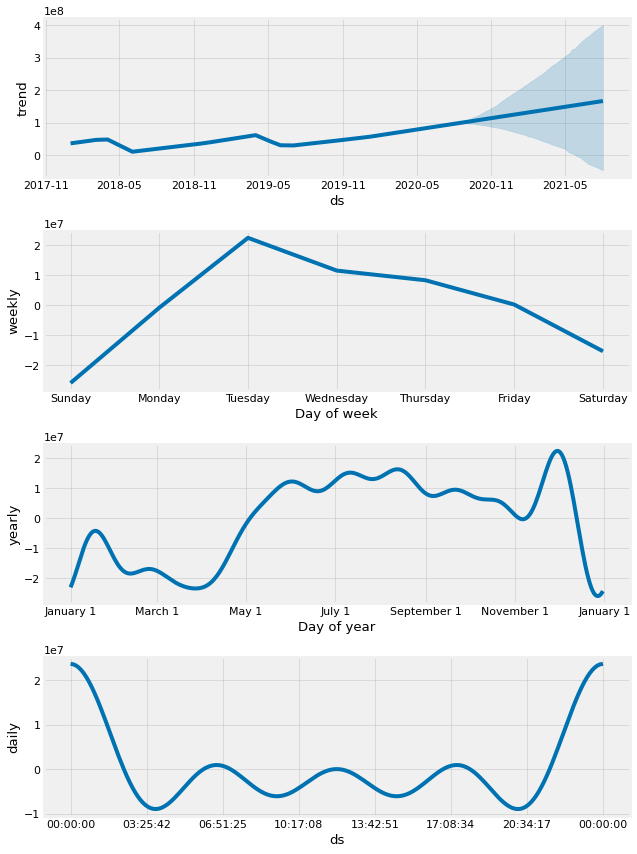

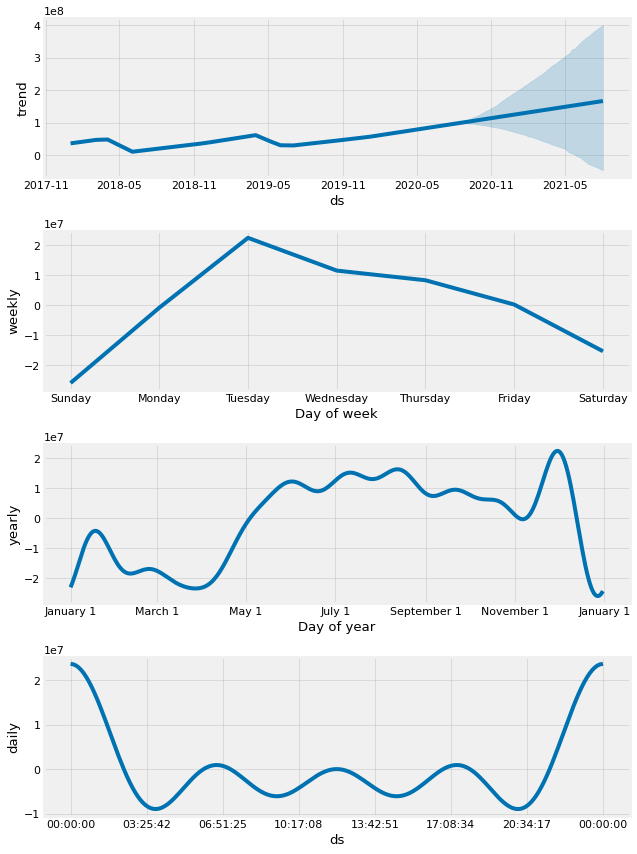

In [ ]:
train_model.plot_components(forecast,(25,10))

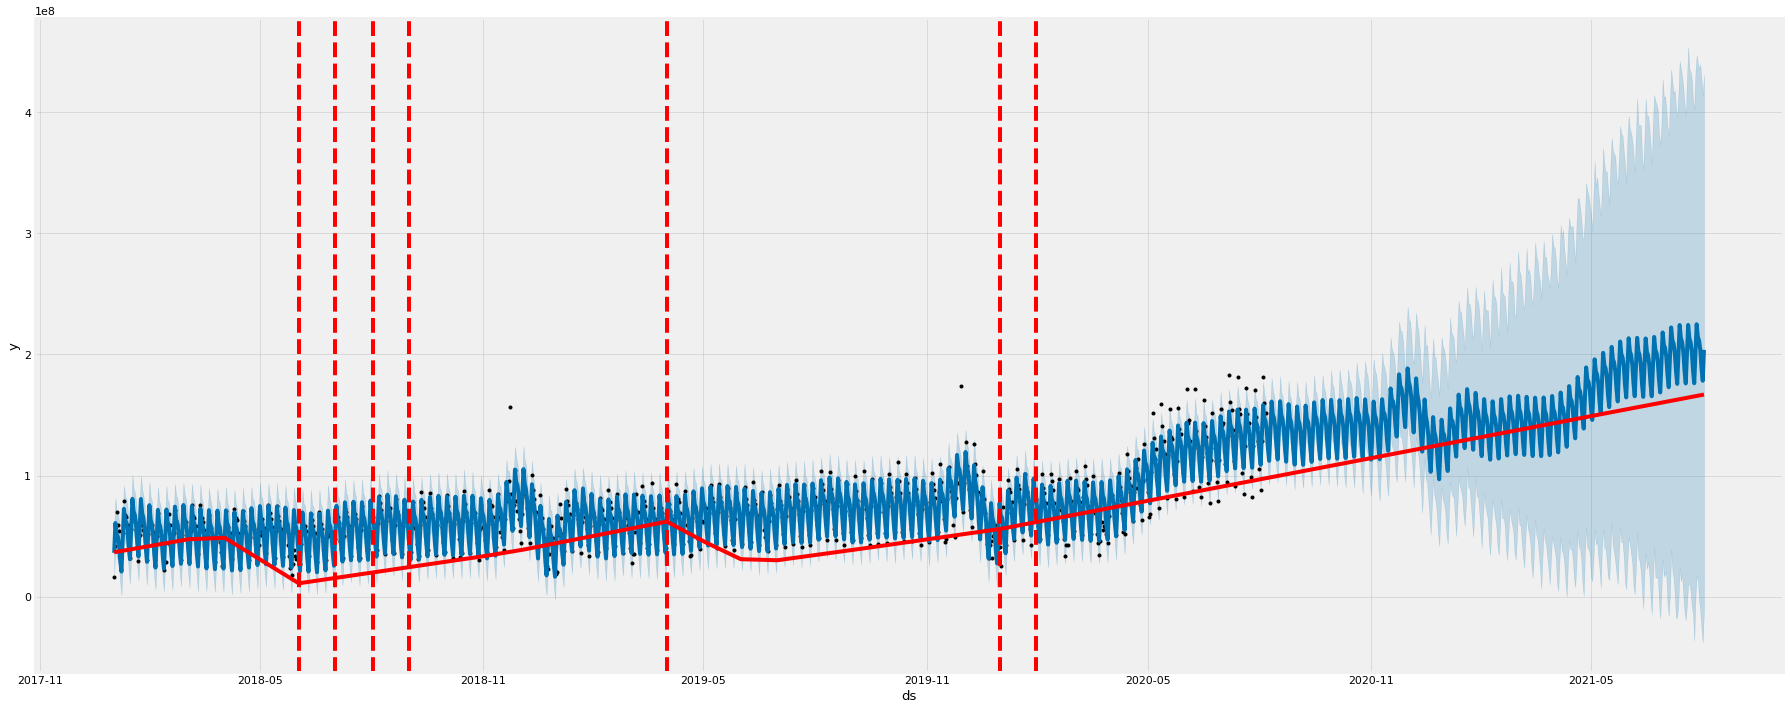

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig1 = train_model.plot(forecast,figsize=(25,10))
b = add_changepoints_to_plot(fig1.gca(), m, forecast)
# Los changepoints marcados en rojo son puntos donde cambia la tendencia de la serie. Prophet los detecta automaticamente pero se pueden meter a mano.